# Mapping heat days in 2050

Projected number of extreme heat days, where temperature exceeds the top 1% of historic values, in the year 2050. This map uses the RCP 8.5 emissions scenario from the 4th National Climate Assessment. [Esri map](https://noaa.maps.arcgis.com/apps/mapviewer/index.html?webmap=196b9785f5f745358daafcf33df4f072) | [Data](https://services8.arcgis.com/O5dJJKQg5b6RjO3d/ArcGIS/rest/services/LOCA_Counties_RCP8_2050/FeatureServer/0)


#### Import Python tools

In [1]:
%load_ext lab_black

In [28]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_grid as altgrid
import numpy as np
from datetime import date
import requests
import json
import plotly
import matplotlib.pyplot as plt
import jenkspy
import matplotlib.colors as colors
from cartopy import crs as ccrs
import glob
from PIL import Image
import us
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
alt.themes.register("grid", altgrid.theme)
alt.themes.enable("grid")

ThemeRegistry.enable('grid')

In [4]:
pd.options.display.max_columns = 10000
pd.options.display.max_rows = 10000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [5]:
today = pd.to_datetime("today").strftime("%Y-%m-%d")

---

## Read data

In [6]:
gdf = gpd.read_file("data/processed/counties_extreme_heat_2020.geojson")

<AxesSubplot:>

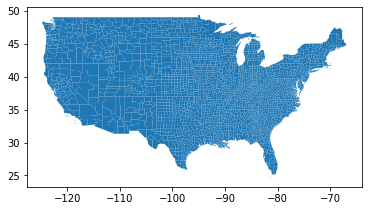

In [7]:
gdf.plot()

---

## Other geography

In [8]:
states = gpd.read_file("/Users/stiles/data/gis/usa_states_esri_simple.json")

In [9]:
states = states[~states["STATE_NAME"].isin(["Alaska", "Hawaii"])]

In [10]:
cities = gpd.read_file("/Users/stiles/data/gis/USA_Major_Cities.geojson")[
    ["NAME", "ST", "CAPITAL", "POPULATION", "geometry"]
]

In [11]:
cities.columns = cities.columns.str.lower()

In [12]:
postal_to_ap = us.states.mapping("abbr", "ap_abbr")
name_to_ap = us.states.mapping("name", "ap_abbr")

In [13]:
cities["st"] = cities["st"].map(postal_to_ap)
gdf["state_ap"] = gdf["state_name"].map(name_to_ap)

In [14]:
big_cities = cities[cities["population"] > 1500000]
big_cities

,name,st,capital,population,geometry
62,Chicago,Ill.,,2781116,POINT (-87.64715 41.75649)
414,Los Angeles,Calif.,,3986442,POINT (-118.27058 34.05279)
909,Phoenix,Ariz.,State,1601381,POINT (-112.07387 33.44611)
2173,New York,N.Y.,,8691599,POINT (-74.01013 40.71057)
2986,Philadelphia,Pa.,,1587761,POINT (-75.16099 39.95136)
3640,Houston,Texas,,2333285,POINT (-95.36751 29.75876)


In [15]:
big_capital_cities = cities[
    (cities["capital"] == "State") & (cities["population"] > 400000)
]
big_capital_cities

,name,st,capital,population,geometry
279,Indianapolis,Ind.,State,864712,POINT (-86.14634 39.77710)
540,Sacramento,Calif.,State,494322,POINT (-121.46830 38.56664)
673,Denver,Colo.,State,699521,POINT (-104.98252 39.72937)
909,Phoenix,Ariz.,State,1601381,POINT (-112.07387 33.44611)
1436,Boston,Mass.,State,661977,POINT (-71.05671 42.35959)
1878,Atlanta,Ga.,State,464043,POINT (-84.39492 33.74864)
2317,Raleigh,N.C.,State,457182,POINT (-78.63539 35.78534)
2386,Columbus,Ohio,State,871273,POINT (-82.98893 39.98840)
2858,Oklahoma City,Okla.,State,665635,POINT (-97.51916 35.46768)
3519,Nashville,Tenn.,State,672371,POINT (-86.77731 36.16647)


In [16]:
our_city_list = ["Tulsa", "Spokane", "Yuma"]
our_cities = cities[cities["name"].isin(our_city_list)]

In [17]:
albo = ccrs.AlbersEqualArea(
    central_longitude=-96,
    central_latitude=37.5,
    false_easting=0.0,
    false_northing=0.0,
    standard_parallels=(29.5, 45.5),
    globe=None,
)

In [18]:
gdf = gdf.to_crs(albo.proj4_init)
states = states.to_crs(albo.proj4_init)
cities = cities.to_crs(albo.proj4_init)
big_cities = big_cities.to_crs(albo.proj4_init)
our_cities = our_cities.to_crs(albo.proj4_init)

---

#### Round down

In [19]:
gdf.loc[gdf["pred_tmax_95f"] < 1, "pred_tmax_95f"] = 0
gdf.loc[gdf["tmax95fhistorical"] < 1, "tmax95fhistorical"] = 0

---

In [20]:
breaks = jenkspy.jenks_breaks(
    list(gdf[~gdf["pred_tmax_95f"].isna()].pred_tmax_95f.fillna(0)), nb_class=7
)
breaks

[0.0,
 15.267551057800926,
 30.58687494695184,
 46.2930301319469,
 64.1534705595278,
 87.1746251106263,
 119.4136166674026,
 167.3904803162911]

In [21]:
manual_breaks = [1, 15, 30, 50, 65, 90, 167]

In [34]:
cmap = ListedColormap(
    ["#dddddd", "#feedde", "#fdd0a2", "#fdae6b", "#fd8d3c", "#e6550d", "#a63603"]
)

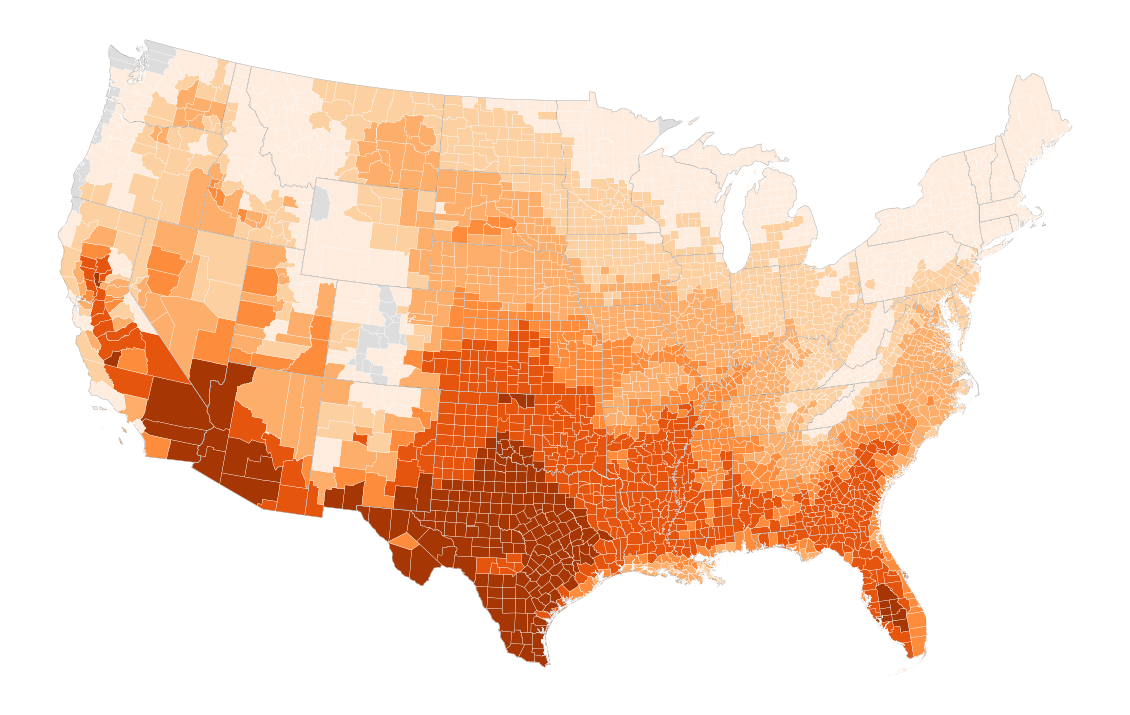

In [35]:
ax = gdf.boundary.plot(edgecolor="white", linewidth=0.2, figsize=(20, 14))

gdf.plot(ax=ax, facecolor="#e9e9e9", edgecolor="#fff", linewidth=0.4)


gdf.plot(
    ax=ax,
    column="pred_tmax_95f",
    legend=False,
    categorical=True,
    cmap=cmap,
    scheme="User_Defined",
    classification_kwds=dict(bins=manual_breaks),
)

states.plot(ax=ax, facecolor="none", edgecolor="#888", linewidth=0.4)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

for edge in ["right", "bottom", "top", "left"]:
    ax.spines[edge].set_visible(False)

# ax.set_title(
#     f"{y}",
#     font="Summit Sans",
#     size=20,
#     weight="bold",
# )

plt.savefig(
    f"visuals/map_2050_after.svg",
    dpi=72,
    transparent=True,
    pad_inches=0,
    bbox_inches="tight",
)

---

## Exports

In [23]:
gdf[
    [
        "name",
        "state_name",
        "state_fips",
        "cnty_fips",
        "fips",
        "tmaxhistorical",
        "tmax",
        "pred_tmax",
        "tmaxdaysabove99thhistorical",
        "pred_days_99th",
        "tavghistorical",
        "pred_tavg",
        "tmax95fhistorical",
        "pred_tmax_95f",
        "population",
        "households",
        "crop_acr17",
        "state_ap",
    ]
].to_csv("data/processed/heat_counties_2025.csv", index=False)

In [24]:
len(gdf[(gdf["pred_tmax_95f"] >= 1) | (gdf["tmax95fhistorical"] >= 1)])

3060

In [25]:
len(gdf)

3108